# Analysis on Used Car Market (2021 - 2024)

## Objective
- Analize **used** car market inventory levels and the price of different automobiles makers, such as, Toyata, Honda, and Mazda, for their SUV and Sedan models.
- Find the best `deal` based on mileage, price, and others factors.
- Possible make purchase in the future based on any insights.

## Methodology
- Since there are several models and trims for each different automobile maker, I will be focusing in some specific model. In the SUV category: `RAV4`, `CX5`, `CR-V` and `Pilot`. For the Sedan category: `Corolla` `Camry`, `Mazda3`, `Mazda6`, `Civic`.
- I will be focusing on cars from 2021 to 2024.
- I will need as much information as I can gather from a single website, such as, current car price, mileage, vehicle history, dealer, days on market. 
- I will be gathering this information from **edmunds** website using the `Selenium` library.

### Hypothesis
- Depending on how much information I am able to gather, I will have different hypothesis.
- My number one hypothesis is that the `price` of a car depends on the number of `mileage`. Low mileage means, high price and vice versa.
- My second hypothesis is that newer models have a higher price.
- Finding a `good` deal on a used car will be a tough task since no two used cars are the same.

### Gathering the Data

In [4]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import StaleElementReferenceException
import pandas as pd
import time
import re

In [ ]:
def save_to_csv(data_list, file_path):
    """Creates a new file if does not exists and appends a list"""

    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(data_list)
    
    # Check if the CSV file already exists
    file_exists = pd.io.common.file_exists(file_path)
    
    # If the file exists, append data without headers
    # Otherwise, write data with headers
    df.to_csv(file_path, mode='a', header=not file_exists, index=False)
    
    print(f"Saving {len(df)} listings...")

In [ ]:
def extract_details(text):
    """Extracts mileage and accidents/owners/usage information from a given text string."""
    
    # Define regex pattern for mileage
    mileage_pattern = r'(\d{1,3}(?:,\d{3})*|\d+) miles'
    
    # Define regex pattern for accidents/owners/usage
    # Match the entire line(s) after mileage
    accidents_owners_usage_pattern = r'(?<=miles\n)(.*)'
    
    # Search for mileage
    mileage_match = re.search(mileage_pattern, text)
    if mileage_match:
        mileage = mileage_match.group(0)
    else:
        mileage = None
    
    # Search for accidents/owners/usage
    accidents_owners_usage_match = re.search(accidents_owners_usage_pattern, text, re.DOTALL)
    if accidents_owners_usage_match:
        accidents_owners_usage = accidents_owners_usage_match.group(1)
        accidents_owners_usage = accidents_owners_usage.split("\n")[0]
    else:
        accidents_owners_usage = None
    
    # Return the extracted information as a dictionary
    return {
        'mileage': mileage,
        'accidents_owners_usage': accidents_owners_usage
    }

In [ ]:
def dict_maker(text):
    """accepts a string and returns a dictionary based on the contents of the string. 
    If a string line contains a semicolon (:), split the line into key and value, and add them to 
    the dictionary. If a string line does not contain a semicolon, generate a key like k1, k2, and so on, 
    and assign the line content as the value."""

    result_dict = {}
    lines = text.split("\n")

    for line in lines:
        line = line.strip()

        if line:
            if ":" in line:
                # Split by semicolon
                k, v = line.split(":", 1)

                k = k.strip()
                v = v.strip()

                # Add key value pair to dict
                result_dict[k] = v
    
    return result_dict

In [ ]:
def page_scraper(driver):
    """Scrapes data from the current page and returns a list of dictionaries with items scraped."""
    vehicle_listings = []
    next_page = False
    next_page_url = ""

    try:
        # Find the list of listings
        unorder_list = driver.find_element(By.CSS_SELECTOR, "ul.usurp-card-list.list-unstyled.align-items-stretch.row")
        listings = unorder_list.find_elements(By.CSS_SELECTOR, "li.d-flex.mb-0_75.mb-md-1_5.col-12.col-md-6")
        
        # Loop through each listing
        for item in listings:
            try:
                # Extract vehicle information
                car_url = item.find_element(By.CSS_SELECTOR, 'a.usurp-inventory-card-vdp-link').get_attribute("href")
                y_m_m = item.find_element(By.CSS_SELECTOR, 'div.size-16.text-cool-gray-10.font-weight-bold.mb-0_5').text
                trim_style = item.find_element(By.CSS_SELECTOR, 'div.font-weight-normal.size-14.text-cool-gray-30').text
                price = item.find_element(By.CSS_SELECTOR, 'span.heading-3').text

                # Extract additional information as dictionary
                details = item.find_element(By.CSS_SELECTOR, 'div.text-gray-darker.row').text
                details_dict = extract_details(details)

                summary = item.find_element(By.CSS_SELECTOR, 'summary.px-0.py-0.small.text-primary-darker.d-flex.align-items-center.size-16.mt-1.justify-content-end')
                if not summary.is_selected():
                    summary.click()
                    time.sleep(0.5)  # Add a delay to allow content to load

                # Extract vehicle history and listing information
                history = item.find_element(By.CSS_SELECTOR, 'section.srp-card-vehicle-history.mb-1').find_element(By.CSS_SELECTOR, 'div.row').text
                history_dict = dict_maker(history)

                listing_info = item.find_element(By.CSS_SELECTOR, 'details.view-more').find_elements(By.CSS_SELECTOR, 'p.xsmall.mb-1')[-1].text
                listing_info_dict = dict_maker(listing_info)

                # Create a dictionary with vehicle information
                vehicle_dict = {
                    'year_make_model': y_m_m,
                    'trim_style': trim_style,
                    'price': price,
                    'url': car_url
                }

                # Update vehicle_dict
                vehicle_dict.update(details_dict)
                vehicle_dict.update(history_dict)
                vehicle_dict.update(listing_info_dict)

                # Add the vehicle_dict to vehicle_listings
                vehicle_listings.append(vehicle_dict)

            except NoSuchElementException:
                # Handle missing elements by skipping the listing
                continue
            except StaleElementReferenceException:
                # Skip the listing if it's no longer valid
                continue
            except Exception as e:
                print(f"Unhandled error processing listing: {e}")
                continue

        # Find and handle the "Next" button for pagination
        next_buttons = driver.find_elements(By.CSS_SELECTOR, 'a.pagination-btn.rounded.d-flex.align-items-center.justify-content-center.text-blue-30.mx-1_5')
        
        if len(next_buttons) > 1:  # Ensure there is more than one button available
            next_button = next_buttons[1]  # Assuming the second button is the "Next" button

            if next_button.get_attribute("aria-disabled") == 'true':
                next_page = False
                next_page_url = ""
            else:
                next_page = True
                next_page_url = next_button.get_attribute("href")
                next_button.click()
                time.sleep(0.5)  # Add a delay for navigation
                
                print(f"NEXT PAGE: {next_page_url}")

        return vehicle_listings, next_page, next_page_url

    except Exception as e:
        print(f"OUTER ERROR: {e}")
        return vehicle_listings, False, ""

In [ ]:
# Initialize a new WebDriver session
def initialize_webdriver(url):
    # Set up Selenium options
    options = Options()
    options.add_argument('--incognito')
    
    driver = webdriver.Chrome(options=options)
    
    # Load the URL
    driver.get(url)
    driver.implicitly_wait(2)
    
    return driver

def close_webdriver(driver):
    if driver:
        driver.quit()

# Main function to perform the scraping and navigation
def main():

    # sedan_url = "path"
    # suv_url = "path"
    default_path = "url_path"
    save_file_path = 'vehicle_data/sedan_vehicles.csv'
    
    # Initialize the WebDriver
    driver = initialize_webdriver(default_path)
    
    while True:
        # Scrape the page and navigate to the next page
        vehicles_list, next_page, new_url = page_scraper(driver)
        
        # Save the scraped data to CSV
        save_to_csv(vehicles_list, save_file_path)
        
        # Check if there is a next page to navigate to
        if next_page:
            # Close the current driver
            close_webdriver(driver)
            
            # Initialize a new WebDriver instance with the updated URL
            driver = initialize_webdriver(new_url)
            time.sleep(0.5)
        else:
            break
    
    close_webdriver(driver)

While running the program in the backgrounf using the terminal, I encounter problems like no such elements exceptions, I modified the program accordingly and there were times where the program crashed and I did not know where it was left, so I added function that saved the last visited url. So there might repated entries in the CSV files that I will have to remove. 

## Cleaning the Data

When I was programming the scraper, one of my objectives was to minimize the cleaning of the data, meaning that If I could put each element into its one column, that would make the cleaning process faster. However, I have to make sure that my data is clean before analyzing.

In [39]:
pd.set_option('display.max_columns', None)

# Read the sedan csv file
sedan_df = pd.read_csv("vehicle_data/sedan_vehicles.csv")
sedan_df

,year_make_model,trim_style,price,url,mileage,accidents_owners_usage,Accident Free Vehicle,Personal Use Only,History Provider,Title Details,Salvage Vehicle,Frame Damage,Theft History,Lemon Status,Free History Report,VIN,Stock,Certified Pre-Owned,Listed since
0,2021 Mazda 3,Select 4dr Hatchback,"$16,998",https://www.edmunds.com/mazda/3/2021/vin/JM1BP...,"19,352 miles","1 Accident, 1 Owner, Personal use",No,Yes,AutoCheck,Clean Title,No,No,No,No,No,JM1BPBKL9M1335023,STK335023,No,02-22-2024
1,2021 Toyota Camry,SE Sedan,"$15,980",https://www.edmunds.com/toyota/camry/2021/vin/...,"71,979 miles","No accidents, 3 Owners, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,4T1G11AK9MU481149,O3963P,No,02-22-2024
2,2021 Toyota Corolla,LE Sedan,"$15,900",https://www.edmunds.com/toyota/corolla/2021/vi...,"18,916 miles","No accidents, 2 Owners, Personal use",Yes,Yes,AutoCheck,Clean Title,No,No,No,No,No,5YFEPMAE0MP171975,71975,No,12-26-2023
3,2022 Toyota Camry,SE Sedan,"$17,500",https://www.edmunds.com/toyota/camry/2022/vin/...,"30,610 miles","No accidents, 2 Owners, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,4T1G11AK7NU703883,03883,No,01-25-2024
4,2021 Honda Civic,Sport Sedan,"$15,400",https://www.edmunds.com/honda/civic/2021/vin/1...,"36,813 miles","No accidents, 2 Owners, Personal use only",Yes,Yes,AutoCheck,Clean Title,No,No,No,No,No,19XFC2F87ME203071,203071,No,11-20-2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5136,2021 Toyota Camry,XSE Sedan,Not Priced,https://www.edmunds.com/toyota/camry/2021/vin/...,NaN,NaN,No,Yes,AutoCheck,Clean Title,No,No,No,No,No,4T1K61AK3MU530261,P8673,No,04-14-2024
5137,2021 Honda Civic,EX Sedan,Not Priced,https://www.edmunds.com/honda/civic/2021/vin/2...,"39,594 miles","1 Accident, 1 Owner, Personal use",No,Yes,AutoCheck,Clean Title,No,No,No,No,No,2HGFC1F37MH701324,36416,No,04-17-2024
5138,2021 Toyota Camry,SE Sedan,"$21,848",https://www.edmunds.com/toyota/camry/2021/vin/...,"58,400 miles","No accidents, 1 Owner, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,4T1G11AK5MU599795,7VK8LP,No,03-07-2024
5139,2021 Honda Civic,Sport 4dr Hatchback,"$21,448",https://www.edmunds.com/honda/civic/2021/vin/S...,"57,878 miles","No accidents, 2 Owners, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,SHHFK7H41MU401695,8DJMRG,No,02-27-2024


- The `price` and `mileage` needs to be converted to numeric type.
- The `year_make_model`, `trim_stryle` and `accidents_owners_usage` columns needs to be split into its own columns.
- The `listed since` column needs to be converted to datetime type.
- Check for any duplicate data using the `VIN` column.

In [40]:
# Replace dollar sign and commas with an empty string
sedan_df['price'] = sedan_df['price'].replace('[$,]', '', regex=True)

# Convert to numeric type
sedan_df['price'] = pd.to_numeric(sedan_df['price'], errors='coerce')

# Replace commas and the word miles with empty string
sedan_df['mileage'] = sedan_df['mileage'].replace('[,miles]', '', regex=True)
sedan_df['mileage'] = pd.to_numeric(sedan_df['mileage'], errors='coerce')

# Conver column to date time type
sedan_df['Listed since'] = pd.to_datetime(sedan_df['Listed since'])

In [41]:
# Check for duplicates
print(sedan_df['VIN'].duplicated().sum())

# Remove duplicates
sedan_df = sedan_df.drop_duplicates(subset='VIN').copy()
sedan_df.shape

1609


(3532, 19)

In [42]:
sedan_df['year_make_model'].unique()

array(['2021 Mazda 3', '2021 Toyota Camry', '2021 Toyota Corolla',
       '2022 Toyota Camry', '2021 Honda Civic', '2023 Toyota Camry',
       '2022 Honda Civic', 'Certified 2023 Honda Civic',
       'Certified 2021 Toyota Corolla', 'Certified 2021 Honda Civic',
       '2023 Honda Civic', '2024 Honda Civic',
       'Certified 2022 Honda Civic', 'Certified 2024 Toyota Corolla',
       'Certified 2021 Mazda 3', 'Certified 2022 Toyota Corolla',
       'Certified 2021 Toyota Camry', 'Certified 2022 Toyota Camry',
       'Certified 2023 Toyota Camry', '2022 Toyota Corolla',
       '2023 Toyota Corolla', 'Certified 2021 Mazda 6',
       'Certified 2023 Toyota Corolla', 'Certified 2023 Mazda 3',
       '2021 Mazda 6', '2024 Toyota Camry', '2022 Mazda 3',
       'Certified 2024 Honda Civic', 'Certified 2024 Toyota Camry',
       '2024 Toyota Corolla', 'Certified 2022 Mazda 3', '2023 Mazda 3',
       '2024 Mazda 3'], dtype=object)

In [43]:
# Replace 'Certified' with an empty string
sedan_df['year_make_model'] = sedan_df['year_make_model'].str.replace('Certified ', '')

sedan_df['year_make_model'].unique()

array(['2021 Mazda 3', '2021 Toyota Camry', '2021 Toyota Corolla',
       '2022 Toyota Camry', '2021 Honda Civic', '2023 Toyota Camry',
       '2022 Honda Civic', '2023 Honda Civic', '2024 Honda Civic',
       '2024 Toyota Corolla', '2022 Toyota Corolla',
       '2023 Toyota Corolla', '2021 Mazda 6', '2023 Mazda 3',
       '2024 Toyota Camry', '2022 Mazda 3', '2024 Mazda 3'], dtype=object)

In [45]:
# Separate the year_make_model into separate columns
sedan_df[['year', 'make', 'model']] =  sedan_df['year_make_model'].str.split(" ", n=2, expand=True)
sedan_df

,year_make_model,trim_style,price,url,mileage,accidents_owners_usage,Accident Free Vehicle,Personal Use Only,History Provider,Title Details,Salvage Vehicle,Frame Damage,Theft History,Lemon Status,Free History Report,VIN,Stock,Certified Pre-Owned,Listed since,year,make,model
0,2021 Mazda 3,Select 4dr Hatchback,16998.0,https://www.edmunds.com/mazda/3/2021/vin/JM1BP...,19352.0,"1 Accident, 1 Owner, Personal use",No,Yes,AutoCheck,Clean Title,No,No,No,No,No,JM1BPBKL9M1335023,STK335023,No,2024-02-22,2021,Mazda,3
1,2021 Toyota Camry,SE Sedan,15980.0,https://www.edmunds.com/toyota/camry/2021/vin/...,71979.0,"No accidents, 3 Owners, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,4T1G11AK9MU481149,O3963P,No,2024-02-22,2021,Toyota,Camry
2,2021 Toyota Corolla,LE Sedan,15900.0,https://www.edmunds.com/toyota/corolla/2021/vi...,18916.0,"No accidents, 2 Owners, Personal use",Yes,Yes,AutoCheck,Clean Title,No,No,No,No,No,5YFEPMAE0MP171975,71975,No,2023-12-26,2021,Toyota,Corolla
3,2022 Toyota Camry,SE Sedan,17500.0,https://www.edmunds.com/toyota/camry/2022/vin/...,30610.0,"No accidents, 2 Owners, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,4T1G11AK7NU703883,03883,No,2024-01-25,2022,Toyota,Camry
4,2021 Honda Civic,Sport Sedan,15400.0,https://www.edmunds.com/honda/civic/2021/vin/1...,36813.0,"No accidents, 2 Owners, Personal use only",Yes,Yes,AutoCheck,Clean Title,No,No,No,No,No,19XFC2F87ME203071,203071,No,2023-11-20,2021,Honda,Civic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5136,2021 Toyota Camry,XSE Sedan,NaN,https://www.edmunds.com/toyota/camry/2021/vin/...,NaN,NaN,No,Yes,AutoCheck,Clean Title,No,No,No,No,No,4T1K61AK3MU530261,P8673,No,2024-04-14,2021,Toyota,Camry
5137,2021 Honda Civic,EX Sedan,NaN,https://www.edmunds.com/honda/civic/2021/vin/2...,39594.0,"1 Accident, 1 Owner, Personal use",No,Yes,AutoCheck,Clean Title,No,No,No,No,No,2HGFC1F37MH701324,36416,No,2024-04-17,2021,Honda,Civic
5138,2021 Toyota Camry,SE Sedan,21848.0,https://www.edmunds.com/toyota/camry/2021/vin/...,58400.0,"No accidents, 1 Owner, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,4T1G11AK5MU599795,7VK8LP,No,2024-03-07,2021,Toyota,Camry
5139,2021 Honda Civic,Sport 4dr Hatchback,21448.0,https://www.edmunds.com/honda/civic/2021/vin/S...,57878.0,"No accidents, 2 Owners, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,SHHFK7H41MU401695,8DJMRG,No,2024-02-27,2021,Honda,Civic


In [46]:
# Split the trim_style into two. In this case, I am assuming that the first index of the split its always the trim.
sedan_df[['trim', 'style']] = sedan_df['trim_style'].str.split(" ", n=1, expand=True)
sedan_df

,year_make_model,trim_style,price,url,mileage,accidents_owners_usage,Accident Free Vehicle,Personal Use Only,History Provider,Title Details,Salvage Vehicle,Frame Damage,Theft History,Lemon Status,Free History Report,VIN,Stock,Certified Pre-Owned,Listed since,year,make,model,trim,style
0,2021 Mazda 3,Select 4dr Hatchback,16998.0,https://www.edmunds.com/mazda/3/2021/vin/JM1BP...,19352.0,"1 Accident, 1 Owner, Personal use",No,Yes,AutoCheck,Clean Title,No,No,No,No,No,JM1BPBKL9M1335023,STK335023,No,2024-02-22,2021,Mazda,3,Select,4dr Hatchback
1,2021 Toyota Camry,SE Sedan,15980.0,https://www.edmunds.com/toyota/camry/2021/vin/...,71979.0,"No accidents, 3 Owners, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,4T1G11AK9MU481149,O3963P,No,2024-02-22,2021,Toyota,Camry,SE,Sedan
2,2021 Toyota Corolla,LE Sedan,15900.0,https://www.edmunds.com/toyota/corolla/2021/vi...,18916.0,"No accidents, 2 Owners, Personal use",Yes,Yes,AutoCheck,Clean Title,No,No,No,No,No,5YFEPMAE0MP171975,71975,No,2023-12-26,2021,Toyota,Corolla,LE,Sedan
3,2022 Toyota Camry,SE Sedan,17500.0,https://www.edmunds.com/toyota/camry/2022/vin/...,30610.0,"No accidents, 2 Owners, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,4T1G11AK7NU703883,03883,No,2024-01-25,2022,Toyota,Camry,SE,Sedan
4,2021 Honda Civic,Sport Sedan,15400.0,https://www.edmunds.com/honda/civic/2021/vin/1...,36813.0,"No accidents, 2 Owners, Personal use only",Yes,Yes,AutoCheck,Clean Title,No,No,No,No,No,19XFC2F87ME203071,203071,No,2023-11-20,2021,Honda,Civic,Sport,Sedan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5136,2021 Toyota Camry,XSE Sedan,NaN,https://www.edmunds.com/toyota/camry/2021/vin/...,NaN,NaN,No,Yes,AutoCheck,Clean Title,No,No,No,No,No,4T1K61AK3MU530261,P8673,No,2024-04-14,2021,Toyota,Camry,XSE,Sedan
5137,2021 Honda Civic,EX Sedan,NaN,https://www.edmunds.com/honda/civic/2021/vin/2...,39594.0,"1 Accident, 1 Owner, Personal use",No,Yes,AutoCheck,Clean Title,No,No,No,No,No,2HGFC1F37MH701324,36416,No,2024-04-17,2021,Honda,Civic,EX,Sedan
5138,2021 Toyota Camry,SE Sedan,21848.0,https://www.edmunds.com/toyota/camry/2021/vin/...,58400.0,"No accidents, 1 Owner, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,4T1G11AK5MU599795,7VK8LP,No,2024-03-07,2021,Toyota,Camry,SE,Sedan
5139,2021 Honda Civic,Sport 4dr Hatchback,21448.0,https://www.edmunds.com/honda/civic/2021/vin/S...,57878.0,"No accidents, 2 Owners, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,SHHFK7H41MU401695,8DJMRG,No,2024-02-27,2021,Honda,Civic,Sport,4dr Hatchback


In [47]:
# SPlit accidents_owners_usage into three columns
sedan_df[['accidents', 'owners', 'usage']] = sedan_df['accidents_owners_usage'].str.split(",", expand=True)
sedan_df

,year_make_model,trim_style,price,url,mileage,accidents_owners_usage,Accident Free Vehicle,Personal Use Only,History Provider,Title Details,Salvage Vehicle,Frame Damage,Theft History,Lemon Status,Free History Report,VIN,Stock,Certified Pre-Owned,Listed since,year,make,model,trim,style,accidents,owners,usage
0,2021 Mazda 3,Select 4dr Hatchback,16998.0,https://www.edmunds.com/mazda/3/2021/vin/JM1BP...,19352.0,"1 Accident, 1 Owner, Personal use",No,Yes,AutoCheck,Clean Title,No,No,No,No,No,JM1BPBKL9M1335023,STK335023,No,2024-02-22,2021,Mazda,3,Select,4dr Hatchback,1 Accident,1 Owner,Personal use
1,2021 Toyota Camry,SE Sedan,15980.0,https://www.edmunds.com/toyota/camry/2021/vin/...,71979.0,"No accidents, 3 Owners, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,4T1G11AK9MU481149,O3963P,No,2024-02-22,2021,Toyota,Camry,SE,Sedan,No accidents,3 Owners,Rental vehicle
2,2021 Toyota Corolla,LE Sedan,15900.0,https://www.edmunds.com/toyota/corolla/2021/vi...,18916.0,"No accidents, 2 Owners, Personal use",Yes,Yes,AutoCheck,Clean Title,No,No,No,No,No,5YFEPMAE0MP171975,71975,No,2023-12-26,2021,Toyota,Corolla,LE,Sedan,No accidents,2 Owners,Personal use
3,2022 Toyota Camry,SE Sedan,17500.0,https://www.edmunds.com/toyota/camry/2022/vin/...,30610.0,"No accidents, 2 Owners, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,4T1G11AK7NU703883,03883,No,2024-01-25,2022,Toyota,Camry,SE,Sedan,No accidents,2 Owners,Rental vehicle
4,2021 Honda Civic,Sport Sedan,15400.0,https://www.edmunds.com/honda/civic/2021/vin/1...,36813.0,"No accidents, 2 Owners, Personal use only",Yes,Yes,AutoCheck,Clean Title,No,No,No,No,No,19XFC2F87ME203071,203071,No,2023-11-20,2021,Honda,Civic,Sport,Sedan,No accidents,2 Owners,Personal use only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5136,2021 Toyota Camry,XSE Sedan,NaN,https://www.edmunds.com/toyota/camry/2021/vin/...,NaN,NaN,No,Yes,AutoCheck,Clean Title,No,No,No,No,No,4T1K61AK3MU530261,P8673,No,2024-04-14,2021,Toyota,Camry,XSE,Sedan,NaN,NaN,NaN
5137,2021 Honda Civic,EX Sedan,NaN,https://www.edmunds.com/honda/civic/2021/vin/2...,39594.0,"1 Accident, 1 Owner, Personal use",No,Yes,AutoCheck,Clean Title,No,No,No,No,No,2HGFC1F37MH701324,36416,No,2024-04-17,2021,Honda,Civic,EX,Sedan,1 Accident,1 Owner,Personal use
5138,2021 Toyota Camry,SE Sedan,21848.0,https://www.edmunds.com/toyota/camry/2021/vin/...,58400.0,"No accidents, 1 Owner, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,4T1G11AK5MU599795,7VK8LP,No,2024-03-07,2021,Toyota,Camry,SE,Sedan,No accidents,1 Owner,Rental vehicle
5139,2021 Honda Civic,Sport 4dr Hatchback,21448.0,https://www.edmunds.com/honda/civic/2021/vin/S...,57878.0,"No accidents, 2 Owners, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,SHHFK7H41MU401695,8DJMRG,No,2024-02-27,2021,Honda,Civic,Sport,4dr Hatchback,No accidents,2 Owners,Rental vehicle


In [48]:
# Check for missing values
sedan_df.isna().sum()

year_make_model              0
trim_style                   2
price                      139
url                          0
mileage                     23
accidents_owners_usage      23
Accident Free Vehicle        0
Personal Use Only            0
History Provider             0
Title Details                0
Salvage Vehicle              0
Frame Damage                 0
Theft History                0
Lemon Status                 0
Free History Report          0
VIN                          0
Stock                        0
Certified Pre-Owned          0
Listed since              1781
year                         0
make                         0
model                        0
trim                         2
style                        2
accidents                   23
owners                      23
usage                       41
dtype: int64

Since there are only 139 records where the price value is missing and 23 rows where the mileage is missing I will removed them. Another approach could be to fill in the missing values with average based on the year, trim, and style, however, no two used cars are the same.

In [49]:
sedan_df = sedan_df.dropna(subset=['price', 'mileage'])

In [50]:
sedan_df.isna().sum()

year_make_model              0
trim_style                   2
price                        0
url                          0
mileage                      0
accidents_owners_usage       0
Accident Free Vehicle        0
Personal Use Only            0
History Provider             0
Title Details                0
Salvage Vehicle              0
Frame Damage                 0
Theft History                0
Lemon Status                 0
Free History Report          0
VIN                          0
Stock                        0
Certified Pre-Owned          0
Listed since              1780
year                         0
make                         0
model                        0
trim                         2
style                        2
accidents                    0
owners                       0
usage                       17
dtype: int64

In [51]:
sedan_df.shape

(3372, 27)

In [12]:
sedan_df.columns

Index(['year_make_model', 'trim_style', 'price', 'url', 'mileage',
       'accidents_owners_usage', 'Accident Free Vehicle', 'Personal Use Only',
       'History Provider', 'Title Details', 'Salvage Vehicle', 'Frame Damage',
       'Theft History', 'Lemon Status', 'Free History Report', 'VIN', 'Stock',
       'Certified Pre-Owned', 'Listed since', 'year', 'make', 'model', 'trim',
       'style', 'accidents', 'owners', 'usage'],
      dtype='object')

In [52]:
# Create a df with the new columns and save to csv file.
sedan_filtered_df = sedan_df[['year', 'make', 'model', 'trim', 'style','price', 'mileage', 'Accident Free Vehicle', 'Personal Use Only', 
                              'History Provider', 'Title Details', 'Salvage Vehicle', 'Frame Damage', 'Theft History', 'Lemon Status', 
                              'Free History Report', 'VIN', 'Stock', 'Certified Pre-Owned', 'Listed since',  'accidents', 'owners', 'usage', 
                              'url']]

# Save to csv file
sedan_filtered_df.to_csv("vehicle_data/sedan_clean.csv", index=False)

I am left with 3,372 records. This will be plenty enough data for me to have an insight of the current used car market and inventory levels. I will repeat the same process for the SUV csv file.

In [14]:
pd.set_option('display.max_columns', None)

# Read the sedan csv file
suv_df = pd.read_csv("vehicle_data/suv_vehicles.csv")
suv_df

,year_make_model,trim_style,price,url,mileage,accidents_owners_usage,Accident Free Vehicle,Personal Use Only,History Provider,Title Details,Salvage Vehicle,Frame Damage,Theft History,Lemon Status,Free History Report,VIN,Stock,Certified Pre-Owned,Listed since
0,Certified 2021 Honda CR-V,EX 4dr SUV,"$24,091",https://www.edmunds.com/honda/cr-v/2021/vin/2H...,"8,435 miles","No accidents, 1 Owner, Personal use",Yes,Yes,AutoCheck,Clean Title,No,No,No,No,No,2HKRW2H59MH613213,HHMH613213U,Yes,03-02-2024
1,2021 Toyota RAV4,LE 4dr SUV,"$18,900",https://www.edmunds.com/toyota/rav4/2021/vin/2...,"26,994 miles","No accidents, 2 Owners, Corporate fleet vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,2T3H1RFV5MW176681,176681,No,09-26-2023
2,2021 Toyota RAV4,LE 4dr SUV,"$19,505",https://www.edmunds.com/toyota/rav4/2021/vin/2...,"34,171 miles","No accidents, 2 Owners, Corporate fleet vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,2T3F1RFV4MC151912,51912,No,01-25-2024
3,Certified 2021 Honda CR-V,EX-L 4dr SUV,"$25,749",https://www.edmunds.com/honda/cr-v/2021/vin/5J...,"17,096 miles","No accidents, 1 Owner, Personal use",Yes,Yes,AutoCheck,Clean Title,No,No,No,No,No,5J6RW2H80MA010260,MA010260,Yes,02-24-2024
4,2021 Toyota RAV4,Adventure 4dr SUV,"$19,695",https://www.edmunds.com/toyota/rav4/2021/vin/2...,"65,860 miles","No accidents, 1 Owner, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,2T3J1RFV3MW161727,3764P,No,01-09-2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,Certified 2021 Honda CR-V,EX 4dr SUV,"$28,999",https://www.edmunds.com/honda/cr-v/2021/vin/2H...,"36,869 miles","1 Accident, 1 Owner, Personal use",No,Yes,AutoCheck,Clean Title,No,No,No,No,No,2HKRW2H54MH613264,29681,Yes,04-06-2024
3648,2021 Toyota RAV4,XLE 4dr SUV,"$28,995",https://www.edmunds.com/toyota/rav4/2021/vin/2...,"61,070 miles","1 Accident, 1 Owner, Personal use",No,Yes,AutoCheck,Clean Title,No,No,No,No,No,2T3P1RFV0MW192685,UT62270T,No,03-05-2024
3649,2024 Honda CR-V,Sport Hybrid 4dr SUV,"$34,999",https://www.edmunds.com/honda/cr-v/2024/vin/5J...,"8,657 miles","No accidents, 1 Owner, Personal use only",Yes,Yes,AutoCheck,Clean Title,No,No,No,No,No,5J6RS6H59RL000816,US9148,No,04-07-2024
3650,2021 Mazda CX-5,Grand Touring 4dr SUV,"$22,995",https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,"49,836 miles","1 Accident, 2 Owners, Personal use",No,Yes,AutoCheck,Clean Title,No,No,No,No,No,JM3KFBDM9M1301793,M1301793,No,01-22-2024


In [15]:
# Replace dollar sing and commas with empty strings
suv_df['price'] = suv_df['price'].replace('[$,]', '', regex=True)

# Convert to numeric type
suv_df['price'] = pd.to_numeric(suv_df['price'], errors='coerce')

# Replace commas and the word miles with empty string
suv_df['mileage'] = suv_df['mileage'].replace('[,miles]', '', regex=True)
suv_df['mileage'] = pd.to_numeric(suv_df['mileage'], errors='coerce')

# Conver column to date time type
suv_df['Listed since'] = pd.to_datetime(suv_df['Listed since'])

# Check for duplicates
print(suv_df['VIN'].duplicated().sum())

# Remove duplicates
suv_df = suv_df.drop_duplicates(subset='VIN').copy()
suv_df.shape

21


(3631, 19)

In [16]:
# Replace 'Certified' with empty string
suv_df['year_make_model'] = suv_df['year_make_model'].str.replace('Certified ', '')

In [17]:
# Separate the year_make_model into separate columns
suv_df[['year', 'make', 'model']] =  suv_df['year_make_model'].str.split(" ", n=2, expand=True)
suv_df

,year_make_model,trim_style,price,url,mileage,accidents_owners_usage,Accident Free Vehicle,Personal Use Only,History Provider,Title Details,Salvage Vehicle,Frame Damage,Theft History,Lemon Status,Free History Report,VIN,Stock,Certified Pre-Owned,Listed since,year,make,model
0,2021 Honda CR-V,EX 4dr SUV,24091.0,https://www.edmunds.com/honda/cr-v/2021/vin/2H...,8435.0,"No accidents, 1 Owner, Personal use",Yes,Yes,AutoCheck,Clean Title,No,No,No,No,No,2HKRW2H59MH613213,HHMH613213U,Yes,2024-03-02,2021,Honda,CR-V
1,2021 Toyota RAV4,LE 4dr SUV,18900.0,https://www.edmunds.com/toyota/rav4/2021/vin/2...,26994.0,"No accidents, 2 Owners, Corporate fleet vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,2T3H1RFV5MW176681,176681,No,2023-09-26,2021,Toyota,RAV4
2,2021 Toyota RAV4,LE 4dr SUV,19505.0,https://www.edmunds.com/toyota/rav4/2021/vin/2...,34171.0,"No accidents, 2 Owners, Corporate fleet vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,2T3F1RFV4MC151912,51912,No,2024-01-25,2021,Toyota,RAV4
3,2021 Honda CR-V,EX-L 4dr SUV,25749.0,https://www.edmunds.com/honda/cr-v/2021/vin/5J...,17096.0,"No accidents, 1 Owner, Personal use",Yes,Yes,AutoCheck,Clean Title,No,No,No,No,No,5J6RW2H80MA010260,MA010260,Yes,2024-02-24,2021,Honda,CR-V
4,2021 Toyota RAV4,Adventure 4dr SUV,19695.0,https://www.edmunds.com/toyota/rav4/2021/vin/2...,65860.0,"No accidents, 1 Owner, Rental vehicle",Yes,No,AutoCheck,Clean Title,No,No,No,No,No,2T3J1RFV3MW161727,3764P,No,2024-01-09,2021,Toyota,RAV4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,2021 Honda CR-V,EX 4dr SUV,28999.0,https://www.edmunds.com/honda/cr-v/2021/vin/2H...,36869.0,"1 Accident, 1 Owner, Personal use",No,Yes,AutoCheck,Clean Title,No,No,No,No,No,2HKRW2H54MH613264,29681,Yes,2024-04-06,2021,Honda,CR-V
3648,2021 Toyota RAV4,XLE 4dr SUV,28995.0,https://www.edmunds.com/toyota/rav4/2021/vin/2...,61070.0,"1 Accident, 1 Owner, Personal use",No,Yes,AutoCheck,Clean Title,No,No,No,No,No,2T3P1RFV0MW192685,UT62270T,No,2024-03-05,2021,Toyota,RAV4
3649,2024 Honda CR-V,Sport Hybrid 4dr SUV,34999.0,https://www.edmunds.com/honda/cr-v/2024/vin/5J...,8657.0,"No accidents, 1 Owner, Personal use only",Yes,Yes,AutoCheck,Clean Title,No,No,No,No,No,5J6RS6H59RL000816,US9148,No,2024-04-07,2024,Honda,CR-V
3650,2021 Mazda CX-5,Grand Touring 4dr SUV,22995.0,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,49836.0,"1 Accident, 2 Owners, Personal use",No,Yes,AutoCheck,Clean Title,No,No,No,No,No,JM3KFBDM9M1301793,M1301793,No,2024-01-22,2021,Mazda,CX-5


In [18]:
# Split the trim_style into two. In this case, I am assuming that the first index of the split its always the trim.
suv_df[['trim', 'style']] = suv_df['trim_style'].str.split(" ", n=1, expand=True)

# Split accidents_owners_usage into three columns
suv_df[['accidents', 'owners', 'usage']] = suv_df['accidents_owners_usage'].str.split(",", expand=True)

In [19]:
# Check for missing values
suv_df.isna().sum()

year_make_model              0
trim_style                   0
price                      177
url                          0
mileage                     10
accidents_owners_usage      10
Accident Free Vehicle        0
Personal Use Only            0
History Provider             0
Title Details                0
Salvage Vehicle              0
Frame Damage                 0
Theft History                0
Lemon Status                 0
Free History Report          0
VIN                          0
Stock                        0
Certified Pre-Owned          0
Listed since              1815
year                         0
make                         0
model                        0
trim                         0
style                        0
accidents                   10
owners                      10
usage                       21
dtype: int64

In [20]:
suv_df = suv_df.dropna(subset=['price', 'mileage'])
suv_df.isna().sum()

year_make_model              0
trim_style                   0
price                        0
url                          0
mileage                      0
accidents_owners_usage       0
Accident Free Vehicle        0
Personal Use Only            0
History Provider             0
Title Details                0
Salvage Vehicle              0
Frame Damage                 0
Theft History                0
Lemon Status                 0
Free History Report          0
VIN                          0
Stock                        0
Certified Pre-Owned          0
Listed since              1814
year                         0
make                         0
model                        0
trim                         0
style                        0
accidents                    0
owners                       0
usage                       11
dtype: int64

In [21]:
suv_df.shape

(3444, 27)

In [22]:
# Create a df with the new columns and save to csv file.
suv_filtered_df = suv_df[['year', 'make', 'model', 'trim', 'style','price', 'mileage', 'Accident Free Vehicle', 'Personal Use Only', 
                          'History Provider', 'Title Details', 'Salvage Vehicle', 'Frame Damage', 'Theft History', 'Lemon Status', 
                          'Free History Report', 'VIN', 'Stock', 'Certified Pre-Owned', 'Listed since',  'accidents', 'owners', 'usage', 
                          'url']]

# Save to csv file
suv_filtered_df.to_csv("vehicle_data/suv_clean.csv", index=False)

### Used Car Inventory Analysis

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Silence all warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)   # Set default figure size (width, height)
plt.style.use('seaborn-v0_8-pastel')

In [6]:
# Read the sedan clean csv file
sedan_df = pd.read_csv('vehicle_data/sedan_clean.csv')
sedan_df.head()

,year,make,model,trim,style,price,mileage,Accident Free Vehicle,Personal Use Only,History Provider,...,Lemon Status,Free History Report,VIN,Stock,Certified Pre-Owned,Listed since,accidents,owners,usage,url
0,2021,Mazda,3,Select,4dr Hatchback,16998.0,19352.0,No,Yes,AutoCheck,...,No,No,JM1BPBKL9M1335023,STK335023,No,2024-02-22,1 Accident,1 Owner,Personal use,https://www.edmunds.com/mazda/3/2021/vin/JM1BP...
1,2021,Toyota,Camry,SE,Sedan,15980.0,71979.0,Yes,No,AutoCheck,...,No,No,4T1G11AK9MU481149,O3963P,No,2024-02-22,No accidents,3 Owners,Rental vehicle,https://www.edmunds.com/toyota/camry/2021/vin/...
2,2021,Toyota,Corolla,LE,Sedan,15900.0,18916.0,Yes,Yes,AutoCheck,...,No,No,5YFEPMAE0MP171975,71975,No,2023-12-26,No accidents,2 Owners,Personal use,https://www.edmunds.com/toyota/corolla/2021/vi...
3,2022,Toyota,Camry,SE,Sedan,17500.0,30610.0,Yes,No,AutoCheck,...,No,No,4T1G11AK7NU703883,03883,No,2024-01-25,No accidents,2 Owners,Rental vehicle,https://www.edmunds.com/toyota/camry/2022/vin/...
4,2021,Honda,Civic,Sport,Sedan,15400.0,36813.0,Yes,Yes,AutoCheck,...,No,No,19XFC2F87ME203071,203071,No,2023-11-20,No accidents,2 Owners,Personal use only,https://www.edmunds.com/honda/civic/2021/vin/1...


In [7]:
# Descriptive statistics of price and mileage
sedan_df.describe()

,year,price,mileage
count,3372.000000,3372.000000,3372.000000
mean,2021.732206,23433.121886,32911.623369
std,0.901428,4208.601001,21210.476741
min,2021.000000,10999.000000,4.000000
25%,2021.000000,20953.000000,15946.250000
50%,2021.000000,22998.000000,28612.500000
75%,2022.000000,25797.000000,53700.500000
max,2024.000000,57995.000000,112227.000000


The dataset contains 3,372 used cards ranging from 2021 to 2024. The average price and mileage is $23,433 and 32,911 miles. The 75th percentile indicates that 75% of the price values are at or below $25,797 and 75% of the miles values are at or below 53,700 miles. This give me an idea of what price range I should be aiming for. However, the price and mileage varies depending on the year. I'd like to break down the describe statistics further by year and see how it defers from the overall dataset. 

In [8]:
sedan_df.groupby(['year'])[['price', 'mileage']].agg(['count', 'min', 'mean', 'max'])

price                                 mileage                       \
     count      min          mean      max   count    min          mean   
year                                                                      
2021  1790  10999.0  21784.949162  43998.0    1790  719.0  40506.081564   
2022   847  15888.0  23723.669421  37998.0     847  495.0  34324.945691   
2023   583  17995.0  26545.970840  57995.0     583   44.0  15300.698113   
2024   152  18900.0  29284.072368  53998.0     152    4.0   3148.500000   

                
           max  
year            
2021  107609.0  
2022  112227.0  
2023   58503.0  
2024   19318.0

There are more car inventory for early year cars than the latest year. The mean price of each year increases which could be due to miles playing a big factor. Less miles means more expensive. However, there are other factors that influences on the price, such as the number of owners, accidents, etc.

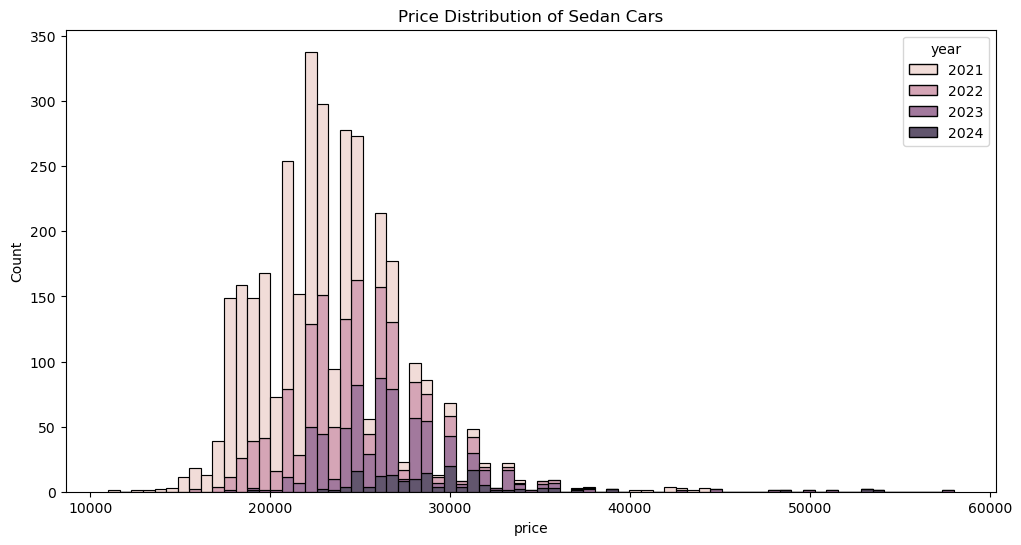

In [62]:
ax = sns.histplot(data=sedan_df, x='price', hue='year', multiple='stack')
plt.title("Price Distribution of Sedan Cars")
plt.show()

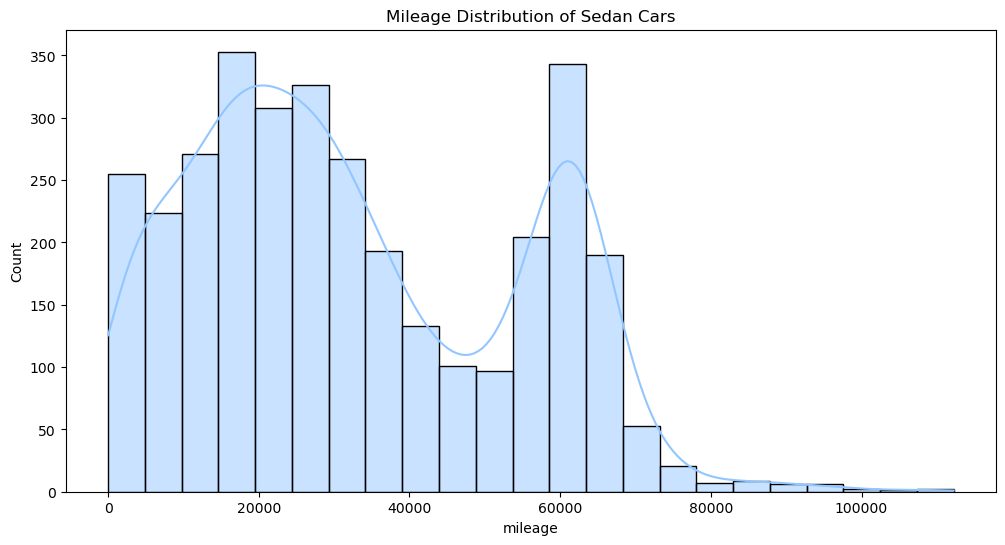

In [70]:
ax = sns.histplot(data=sedan_df, x='mileage', kde='True')
plt.title('Mileage Distribution of Sedan Cars')
plt.show()

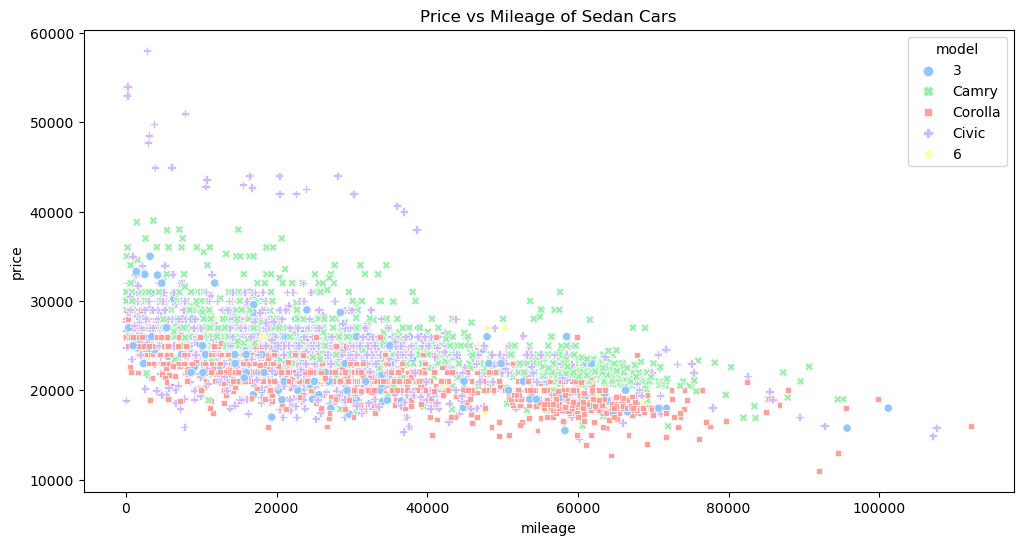

In [139]:
sns.scatterplot(data=sedan_df, x='mileage', y='price', hue='model', style='model')
plt.title("Price vs Mileage of Sedan Cars")
plt.show()

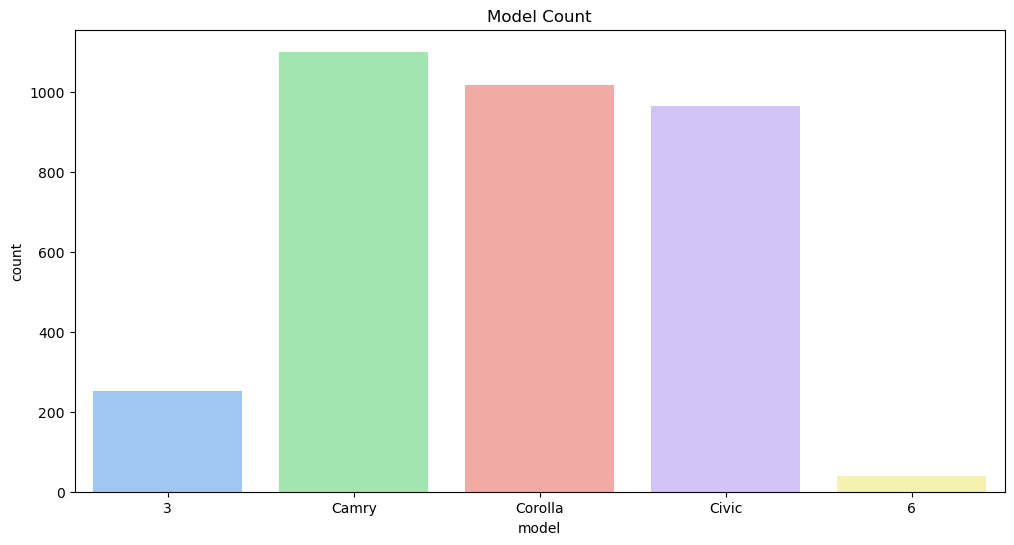

In [140]:
sns.countplot(sedan_df, x='model')
plt.title('Model Count')
plt.show()